To-do:
* Table of contents
* Conclusion
* GitHub README

# Predicting LendingClub Loan Charge-offs from Application Data

***By Joe Corliss***

**June 11, 2018**

## Table of Contents

1. [Summary](#1)
    1. [Spoilers](#1.1)

# Introduction

LendingClub is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a model to predict the probability that a loan will charge-off. We will only use data available to investors before the loan is funded, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan request (amount, purpose, grade, interest rate, etc.). Such a predictive model could help investors make better-informed investment decisions.

## Sources

* LendingClub
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source
 * [Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Data
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project
* This project
 * [Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73)
 * [GitHub repo](https://github.com/jgcorliss/lending-club)

# Import the Data
<a id="2"></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe:

In [2]:
loans = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip', low_memory=True)

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info:

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


There are 1.6 million rows and 150 variables. The size of the dataset is 1.8 GB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [4]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
701291,111429454,NaN,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,B5,controls engineer,7 years,OWN,72800.0,Verified,Jun-2017,Current,n,NaN,debt_consolidation,Debt consolidation,480xx,MI,6.81,0.0,Feb-1998,710.0,714.0,1.0,NaN,NaN,5.0,0.0,16834.0,54.7,6.0,w,21157.61,21157.61,3969.160000,3969.16,2842.39,1126.77,0.0,0.0,0.0,Dec-2017,797.03,Jan-2018,Dec-2017,734.0,730.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,16834.0,1.0,0.0,0.0,0.0,232.0,0.0,NaN,1.0,1.0,5832.0,55.0,30800.0,0.0,0.0,1.0,1.0,3367.0,10559.0,59.1,0.0,0.0,232.0,194.0,2.0,2.0,0.0,68.0,NaN,2.0,NaN,0.0,4.0,5.0,4.0,4.0,1.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,30800.0,16834.0,25800.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1191530,120015735,NaN,37200.0,37200.0,37200.0,60 months,9.93,789.11,B,B2,Salon Manager,4 years,MORTGAGE,107000.0,Verified,Sep-2017,Current,n,NaN,debt_consolidation,Debt consolidation,374xx,TN,6.69,0.0,Mar-2007,735.0,739.0,0.0,NaN,NaN,10.0,0.0,13546.0,24.6,17.0,w,36233.46,36233.46,1537.180000,1537.18,966.54,570.64,0.0,0.0,0.0,Dec-2017,789.11,Jan-2018,Dec-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,183447.0,0.0,1.0,1.0,3.0,10.0,7148.0,64.0,3.0,6.0,5968.0,31.0,55100.0,0.0,2.0,0.0,10.0,18345.0,41554.0,24.6,0.0,0.0,122.0,126.0,8.0,8.0,1.0,8.0,NaN,13.0,NaN,0.0,7.0,7.0,8.0,9.0,5.0,8.0,11.0,7.0,10.0,0.0,0.0,0.0,4.0,100.0,12.5,0.0,0.0,232227.0,20694.0,55100.0,11189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [5]:
loans['loan_status'].value_counts(dropna=False)

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [6]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [7]:
loans.shape

(814986, 150)

There are 814,986 loans remaining. Check that the statuses are as expected:

In [8]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

Status counts as percentages:

In [9]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 21% have charged off, so we have a somewhat unbalanced classification problem.

# Variable Selection (Domain-specific)

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available before the loan is funded.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## Drop features missing more than 30% data

First calculate the percentage of missing data for each feature:

In [10]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [11]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.999876
sec_app_mths_since_last_major_derog           0.999628
hardship_length                               0.999275
hardship_type                                 0.999275
hardship_reason                               0.999275
hardship_status                               0.999275
deferral_term                                 0.999275
hardship_amount                               0.999275
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0,0.5,'Feature count')

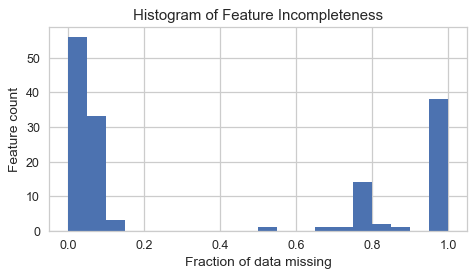

In [12]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [13]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [14]:
len(drop_list)

58

Drop these features:

In [15]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [16]:
loans.shape

(814986, 92)

## Only retain features available before the loan was funded
<a id="4.4"></a>

We examine the LendingClub Data Dictionary to determine which features would have been available to investors before the loan was funded. Here's the list of features we currently have, in alphabetical order:

In [17]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors before deciding to fund the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate. When in doubt, we err on the side of not keeping the feature.

In [18]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'sub_grade', 'term', 'title', 'verification_status', 'zip_code']

In [19]:
len(keep_list)

27

The list of features to drop is any feature not in `keep_list`:

In [20]:
drop_list = [feature for feature in loans.columns if feature not in keep_list]

In [21]:
len(drop_list)

65

Drop these features:

In [22]:
loans.drop(labels=drop_list, axis=1, inplace=True)

# Pre-processing and Exploratory Analysis

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [23]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [24]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'pub_rec', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [25]:
loans['id'].sample(5)

1160023    85678439
971643      1401450
686020     38558688
898100      5254921
46714      31167632
Name: id, dtype: object

Are all the IDs unique?

In [26]:
loans['id'].describe()

count       814986
unique      814986
top       14680062
freq             1
Name: id, dtype: int64

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [27]:
loans.drop('id', axis=1, inplace=True)

## loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [28]:
loans['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


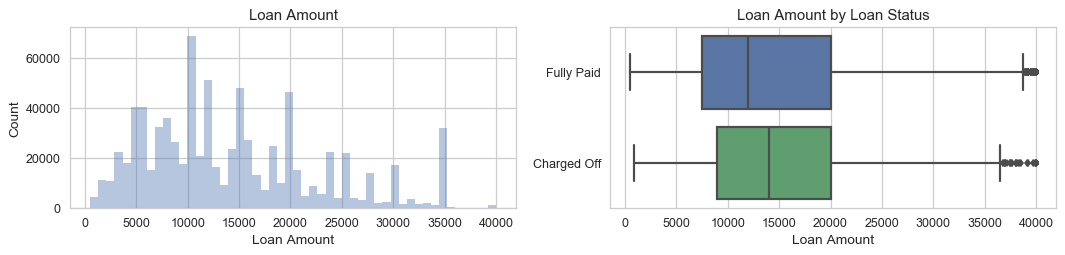

In [29]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [30]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,15384.975964,8606.476332,900.0,9000.0,14000.0,20000.0,40000.0
Fully Paid,646902.0,14037.566316,8449.740674,500.0,7500.0,12000.0,20000.0,40000.0


## term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [31]:
loans['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert `term` to integers.

In [32]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [33]:
loans['term'].value_counts(normalize=True)

36    0.75886
60    0.24114
Name: term, dtype: float64

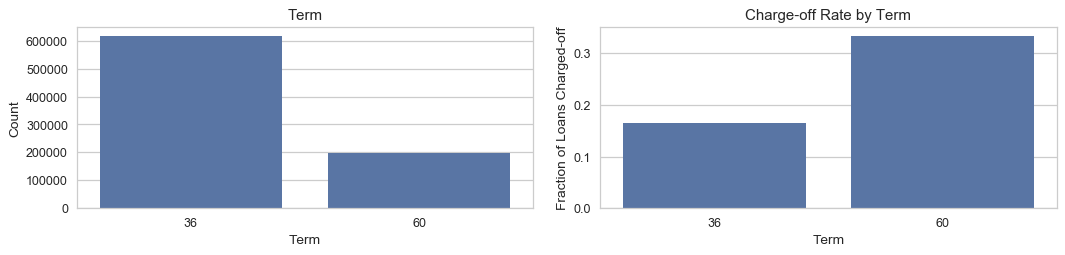

In [34]:
plot_var('term', 'Term', continuous=False)

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more likely to charge off.

## int_rate

Data Dictionary: "Interest Rate on the loan."

In [35]:
loans['int_rate'].describe()

count    814986.000000
mean         13.490993
std           4.618486
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.32% to 30.99% (!) with a median of 13.1%.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


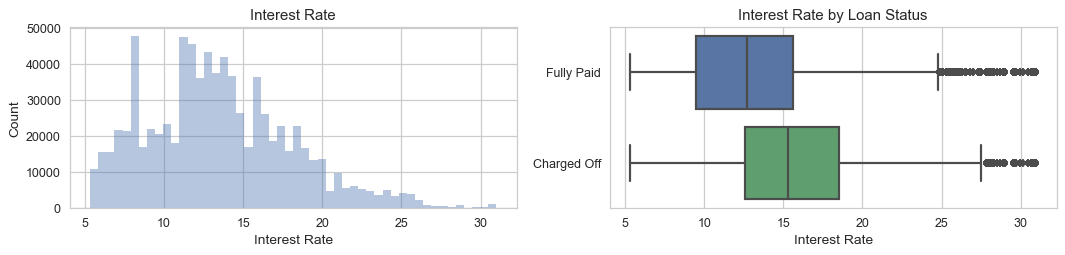

In [36]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [37]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,15.736335,4.625755,5.32,12.59,15.31,18.55,30.99
Fully Paid,646902.0,12.907587,4.434262,5.32,9.49,12.68,15.61,30.99


## installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [38]:
loans['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


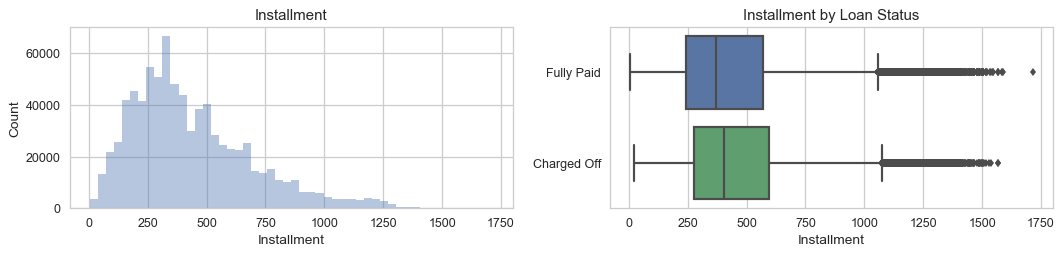

In [39]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [40]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,459.973673,255.309267,21.62,276.14,402.39,595.87,1569.11
Fully Paid,646902.0,430.715339,255.496761,4.93,244.76,370.92,569.72,1714.54


Loans that charge off have \$30 higher installments on average.

## grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [41]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [42]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [43]:
loans.drop('grade', axis=1, inplace=True)

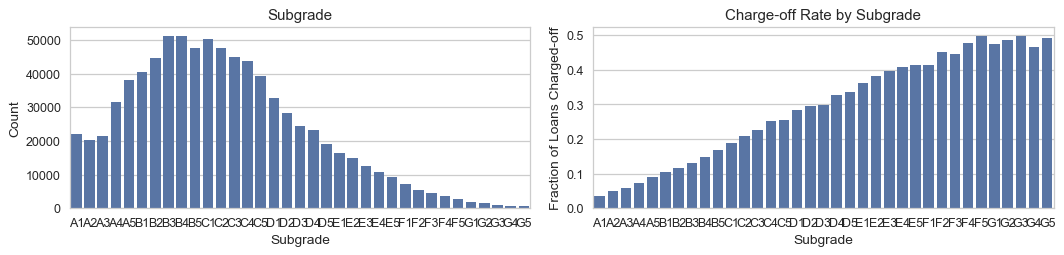

In [44]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [45]:
loans['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [46]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [47]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [48]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [49]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [50]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [51]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [52]:
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

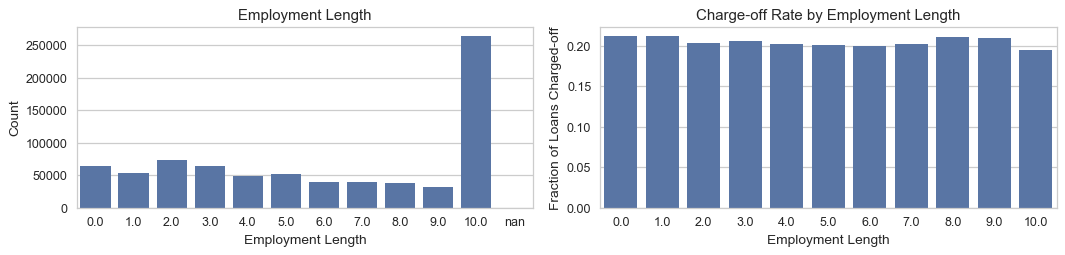

In [53]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [54]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [55]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [56]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          284
Name: home_ownership, dtype: int64

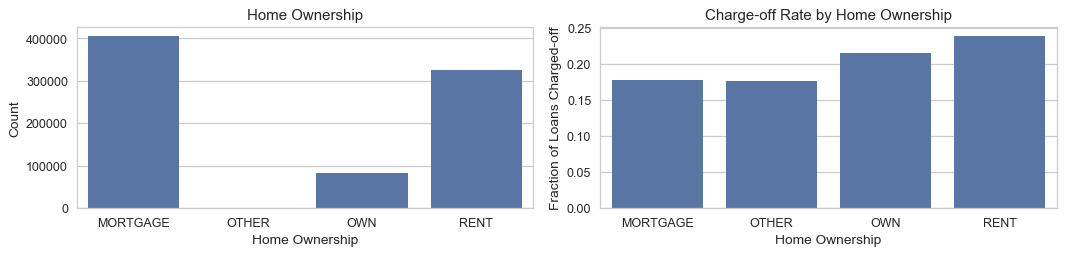

In [57]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [58]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.177808
OTHER       0.176056
OWN         0.215804
RENT        0.239422
Name: loan_status, dtype: float64

## annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [59]:
loans['annual_inc'].describe()

count    8.149860e+05
mean     7.523039e+04
std      6.524373e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [60]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [61]:
loans.drop('annual_inc', axis=1, inplace=True)

In [62]:
loans['log_annual_inc'].describe()

count    814986.000000
mean          4.810836
std           0.231893
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.980003
Name: log_annual_inc, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


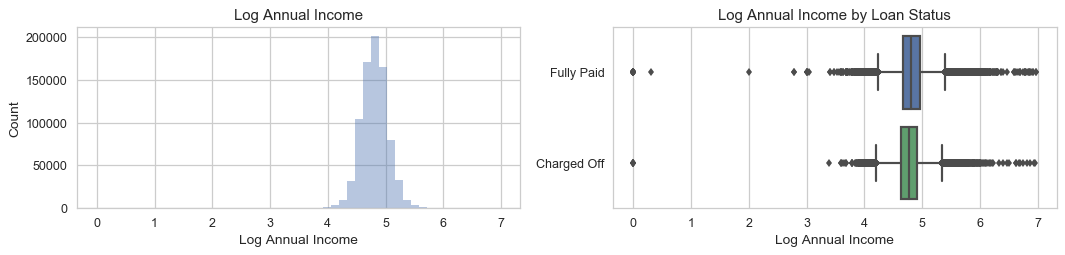

In [63]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [64]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,4.777072,0.227015,0.0,4.632467,4.778158,4.915096,6.949393
Fully Paid,646902.0,4.819608,0.232342,0.0,4.672107,4.812920,4.963793,6.980003


In dollar terms, the median income of charged off loans is...

In [65]:
10**4.778158 - 1

59999.93250120663

And the median income of fully paid loans is...

In [66]:
10**4.812920 - 1

64999.99430578822

So loans that are fully paid have a \$5,000 higher median annual income.

## verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [67]:
loans['verification_status'].value_counts(dropna=False)

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

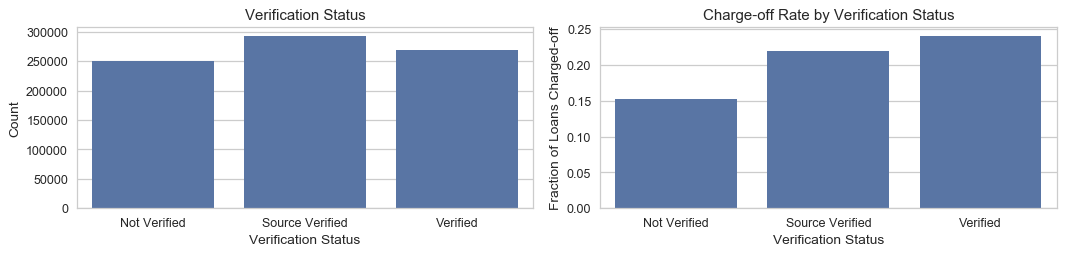

In [68]:
plot_var('verification_status', 'Verification Status', continuous=False)

## issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [69]:
loans['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [70]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121919
car                   0.148053
educational           0.171779
credit_card           0.178412
home_improvement      0.181383
major_purchase        0.183245
vacation              0.198788
house                 0.214652
other                 0.216970
debt_consolidation    0.217398
medical               0.229366
moving                0.242969
renewable_energy      0.247078
small_business        0.302428
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

## title

Data Dictionary: "The loan title provided by the borrower."

In [71]:
loans['title'].describe()

count                 807068
unique                 60298
top       Debt consolidation
freq                  371874
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [72]:
loans['title'].value_counts().head(10)

Debt consolidation         371874
Credit card refinancing    133334
Home improvement            39171
Other                       33265
Debt Consolidation          15059
Major purchase              12311
Medical expenses             6908
Business                     6666
Car financing                5667
Consolidation                5090
Name: title, dtype: int64

There are 60,298 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [73]:
loans.drop('title', axis=1, inplace=True)

## zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [74]:
loans['zip_code'].sample(5)

769479     070xx
838604     330xx
1446738    537xx
217653     131xx
695289     460xx
Name: zip_code, dtype: object

In [75]:
loans['zip_code'].nunique()

925

In [76]:
loans['addr_state'].sample(5)

396365    CA
668991    NJ
620211    AL
69542     WA
182322    NY
Name: addr_state, dtype: object

In [77]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [78]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [79]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.130378
ME    0.136564
NH    0.142554
IA    0.142857
VT    0.149225
OR    0.152827
CO    0.158083
WA    0.166538
KS    0.171004
SC    0.172705
WI    0.175315
MT    0.177759
WY    0.178142
UT    0.179049
WV    0.182457
CT    0.183810
GA    0.191224
MA    0.192974
IL    0.193302
ID    0.193487
RI    0.194009
CA    0.198303
AZ    0.199321
TX    0.202286
AK    0.204141
HI    0.204535
DE    0.206575
VA    0.207942
MI    0.208880
MN    0.210363
PA    0.214776
MD    0.214845
NC    0.215282
NJ    0.216208
KY    0.216353
MO    0.219400
FL    0.222007
OH    0.225400
NM    0.225694
SD    0.225787
NY    0.227045
IN    0.228179
TN    0.230479
NV    0.234202
ND    0.237232
LA    0.237900
AR    0.243154
AL    0.247650
OK    0.248252
NE    0.267946
MS    0.275619
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

## dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [80]:
loans['dti'].describe()

count    814950.000000
mean         17.867719
std           8.856477
min          -1.000000
25%          11.640000
50%          17.360000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Debt-to-income Ratio')

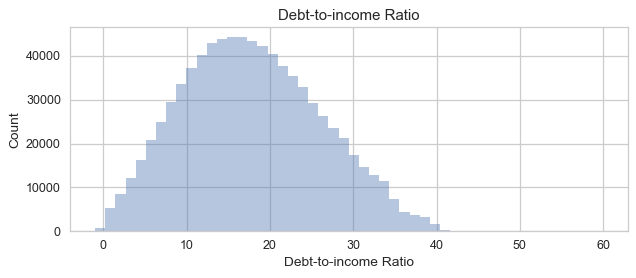

In [81]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [82]:
(loans['dti']>=60).sum()

179

Very few. Compare the summary statistics by loan status:

In [83]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168078.0,20.005334,8.991035,0.0,13.65,19.77,26.21,999.0
Fully Paid,646872.0,17.312298,8.735991,-1.0,11.22,16.77,22.90,999.0


Completed loans that are charged off tend to have higher debt-to-income ratios.

## earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [84]:
loans['earliest_cr_line'].sample(5)

30251      Feb-2005
922026     Aug-1999
1485140    Oct-2005
949955     Oct-1983
834347     Sep-1999
Name: earliest_cr_line, dtype: object

In [85]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [86]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [87]:
loans['earliest_cr_line'].describe()

count    814986.000000
mean       1998.170962
std           7.385629
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


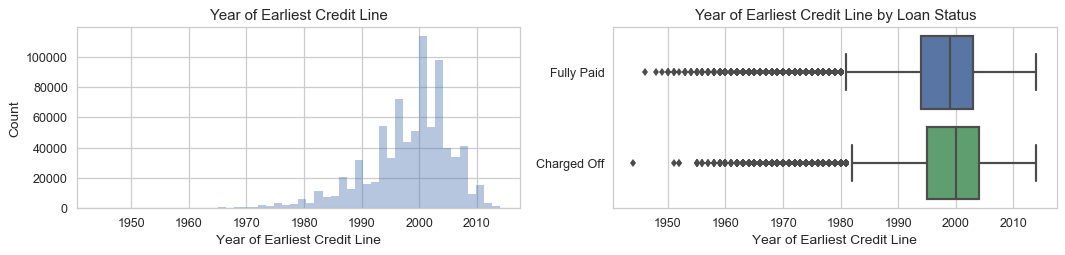

In [88]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [89]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,814986.000000,814986.000000
mean,695.603151,699.603264
std,31.352251,31.352791
min,625.000000,629.000000
25%,670.000000,674.000000
50%,690.000000,694.000000
75%,710.000000,714.000000
max,845.000000,850.000000


Check the Pearson correlation between these values:

In [90]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [91]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [92]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


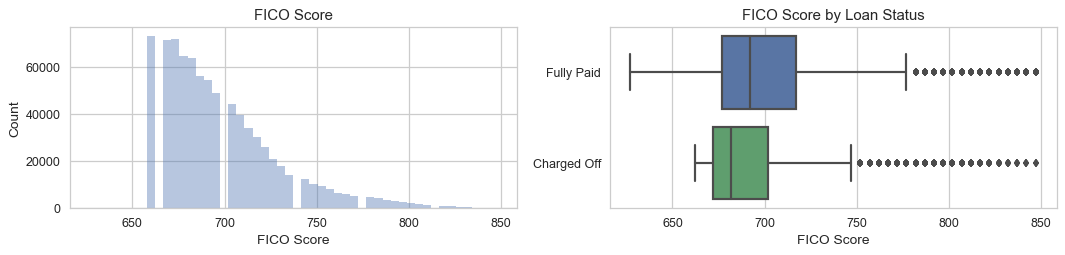

In [93]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [94]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,689.027278,25.083105,662.0,672.0,682.0,702.0,847.5
Fully Paid,646902.0,699.831485,32.416650,627.0,677.0,692.0,717.0,847.5


Loans that charge off have a FICO score 10 points lower on average.

## pub_rec

Data Dictionary: "Number of derogatory public records."

In [100]:
loans['pub_rec'].value_counts().sort_index()

0.0     681509
1.0     112483
2.0      14115
3.0       4107
4.0       1400
5.0        651
6.0        338
7.0        146
8.0         90
9.0         42
10.0        28
11.0        24
12.0        15
13.0        11
14.0         2
15.0         5
16.0         2
17.0         1
18.0         3
19.0         2
21.0         1
24.0         1
28.0         2
34.0         1
40.0         1
46.0         1
49.0         2
54.0         1
63.0         1
86.0         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [99]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,0.232247,0.640855,0.0,0.0,0.0,0.0,86.0
Fully Paid,646902.0,0.198845,0.569304,0.0,0.0,0.0,0.0,63.0


## initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

In [101]:
loans['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

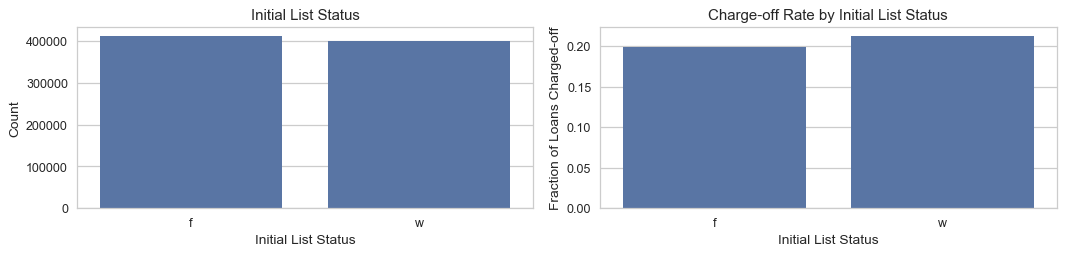

In [102]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [108]:
loans['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [109]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.206316
Joint App     0.190262
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## mort_acc

Data Dictionary: "Number of mortgage accounts."

In [110]:
loans['mort_acc'].describe()

count    767705.000000
mean          1.758707
std           2.081730
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do.

Top 10 values:

In [111]:
loans['mort_acc'].value_counts().head(10)

0.0    301446
1.0    131811
2.0    109869
3.0     82723
4.0     58698
5.0     37090
6.0     21817
7.0     11568
8.0      5906
9.0      3056
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [114]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,161198.0,1.447437,1.901888,0.0,0.0,1.0,2.0,29.0
Fully Paid,606507.0,1.841436,2.119298,0.0,0.0,1.0,3.0,51.0


Individuals who pay off their loans are more likely to have several mortgage accounts.

## pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [116]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     714642
1.0      93680
2.0       4673
3.0        926
4.0        234
5.0         85
6.0         28
7.0         14
8.0          5
9.0          1
12.0         1
Name: pub_rec_bankruptcies, dtype: int64

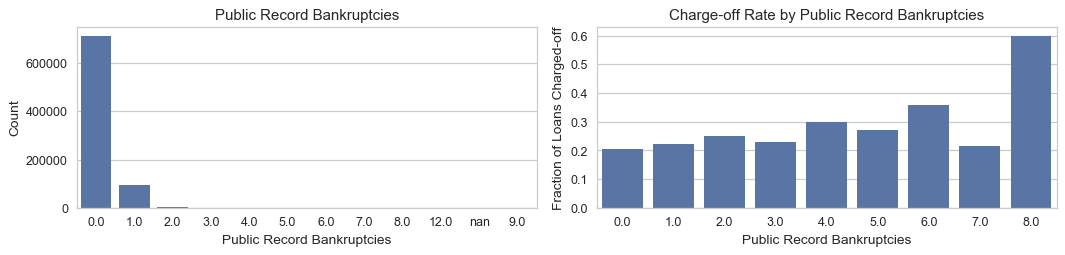

In [117]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# More Pre-processing

## Convert Loan Status to Binary

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [ ]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## Create Dummy Variables

How many variables do we currently have?

In [ ]:
loans.shape[1]

Which variables have missing values?

In [ ]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [ ]:
missing_fractions[missing_fractions > 0]

There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [ ]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [ ]:
loans.shape

Check our data with the new dummy variables:

In [ ]:
loans.sample(3)

Looks good!

## Train/test split

We'll make our predictions more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict the outcome of loans funded on later dates.

The variable `issue_d` includes the month which the loan was funded. Let's peek at this variable:

In [ ]:
loans['issue_d'].sample(5)

So `issue_d` only includes month and year data. Are there any missing values?

In [ ]:
loans['issue_d'].isnull().any()

No. Let's convert the issue dates to datetime objects:

In [ ]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [ ]:
loans['issue_d'].sample(5)

The `issue_d` values got converted to dates, all on the first day of the month. Check summary statistics of the issue dates:

In [ ]:
loans['issue_d'].describe()

Note there are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded per year?

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of loans funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [ ]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [ ]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

The partition looks good, so we can delete the original `loans` dataframe.

In [ ]:
del loans

Let's look at the summary statistics of the issue dates in the train/validation/test sets:

In [ ]:
loans_train['issue_d'].describe()

In [ ]:
loans_test['issue_d'].describe()

The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to September 2017.

Now we can delete the `issue_d` variable, because it was not available before the loan was funded.

In [ ]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:

In [ ]:
X_train = loans_train.drop('charged_off', axis=1)
y_train = loans_train['charged_off']
X_test = loans_test.drop('charged_off', axis=1)
y_test = loans_test['charged_off']

In [ ]:
del loans_train, loans_test

## Check missing data

How complete is our training data?

In [ ]:
missing_fractions = X_train.isnull().mean().sort_values(ascending=False)

In [ ]:
missing_fractions[missing_fractions > 0]

As part of a machine learning pipeline, we'll perform mean imputation of the missing data.

# Linear Correlations with Loan Status

In [ ]:
linear_dep = pd.DataFrame()

In [ ]:
for col in X_train.columns:
    linear_dep.loc[col, 'corr'] = X_train[col].corr(y_train)
linear_dep['abs_corr'] = abs(linear_dep['corr'])

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
for col in X_train.columns:
    mask = X_train[col].notnull()
    linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p'] = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

In [ ]:
linear_dep.sort_values('abs_corr', ascending=True, inplace=True)

In [ ]:
linear_dep.iloc[-20:, [0,2,3]]

# Model Training and Testing

## Logistic regression with stochastic gradient descent

The SGDClassifier implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the `loss` hyperparameter.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.linear_model import SGDClassifier

In [ ]:
pipeline_sgdlogreg = Pipeline([
    ('imputation', Imputer(copy=False)),
    ('standardization', StandardScaler(copy=False)),
    ('classifier', SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [ ]:
from sklearn.model_selection import cross_val_score
cvscores_sgdlogreg = cross_val_score(estimator=pipeline_sgdlogreg, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=-1, pre_dispatch='2*n_jobs')

In [ ]:
print(cvscores_sgdlogreg)
print(cvscores_sgdlogreg.mean())

## Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline_rfc = Pipeline([
    ('imputation', Imputer(copy=False)),
    ('standardization', StandardScaler(copy=False)),
    ('classifier', RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=1))
])

In [ ]:
cvscores_rfc = cross_val_score(estimator=pipeline_rfc, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=-1, pre_dispatch='2*n_jobs')

In [ ]:
print(cvscores_rfc)
print(cvscores_rfc.mean())

## Tune hyperparameters of the chosen model

It looks like logistic regression performs best, so we'll tune the hyperparameters of logistic regression using 5-fold cross validation.

In [ ]:
param_grid = {
    'classifier__alpha': [10**p for p in np.arange(-4, 3, 1)],
    'classifier__penalty': ['l1', 'l2']
}

print(param_grid)

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Run the grid search (this could take some time).

In [ ]:
grid_sgdlogreg.fit(X_train, y_train)

View full results of the grid search:

In [ ]:
pd.DataFrame(grid_sgdlogreg.cv_results_)

Hyperparameters that gave the best results on the hold out data:

In [ ]:
grid_sgdlogreg.best_params_

Mean cross-validated AUCROC score of the best estimator:

In [ ]:
grid_sgdlogreg.best_score_

## Test set evaluation
<a id="8.2"></a>

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

# Conclusion